In [1]:
%matplotlib inline

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys

from collections import defaultdict

1.

In [2]:
def simple_policy(observation):
    players_current_sum, dealer_showing_card, player_usable_ace = observation
    return 0 if players_current_sum >= 19 else 1

In [3]:
def run_episode(game_env, game_policy):
    state = game_env.reset()
    episode = []
    done = False
    for _ in range(100):
        action = game_policy(state)
        next_state, reward, done, _ = game_env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state

    return episode

In [4]:
def mc(policy, env, num_episodes, discount_factor=1.0):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for idx in range(1, num_episodes + 1):
        if idx % 1000 == 0:
            print(f"\rHand {idx}/{num_episodes}.", end="")
            sys.stdout.flush()

        # [((13, 10, False), 1, 0.0), ((20, 10, False), 0, 1.0)]
        episode = run_episode(env, policy)

        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # first occurance
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            G = sum([x[2] * (discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])

            # avg return
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V

In [5]:
env = gym.make('Blackjack-v0')
EPISODES = 100000

In [6]:
V_simple = mc(simple_policy, env, num_episodes=EPISODES)

Hand 1000/100000.
Hand 2000/100000.
Hand 3000/100000.
Hand 4000/100000.
Hand 5000/100000.
Hand 6000/100000.
Hand 7000/100000.
Hand 8000/100000.
Hand 9000/100000.
Hand 10000/100000.
Hand 11000/100000.
Hand 12000/100000.
Hand 13000/100000.
Hand 14000/100000.
Hand 15000/100000.
Hand 16000/100000.
Hand 17000/100000.
Hand 18000/100000.
Hand 19000/100000.
Hand 20000/100000.
Hand 21000/100000.
Hand 22000/100000.
Hand 23000/100000.
Hand 24000/100000.
Hand 25000/100000.
Hand 26000/100000.
Hand 27000/100000.
Hand 28000/100000.
Hand 29000/100000.
Hand 30000/100000.
Hand 31000/100000.
Hand 32000/100000.
Hand 33000/100000.
Hand 34000/100000.
Hand 35000/100000.
Hand 36000/100000.
Hand 37000/100000.
Hand 38000/100000.
Hand 39000/100000.
Hand 40000/100000.
Hand 41000/100000.
Hand 42000/100000.
Hand 43000/100000.
Hand 44000/100000.
Hand 45000/100000.
Hand 46000/100000.
Hand 47000/100000.
Hand 48000/100000.
Hand 49000/100000.
Hand 50000/100000.
Hand 51000/100000.
Hand 52000/100000.
Hand 53000/100000.
Ha

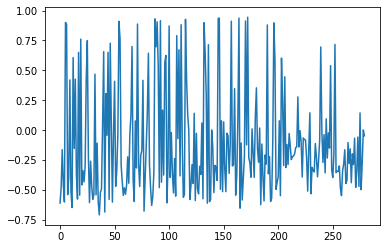

-0.10936063440016831

In [27]:
x = [i for i in V_simple.values()] 
plt.plot(x)
plt.show()
np.mean(x)

In [28]:
def generate_episode(policy, env):
    states, rewards = [], []
    observation = env.reset()
    done = False
    while not done:
        states.append(observation)
        observation, reward, done, info = env.step(policy(observation))
        rewards.append(reward)
    return states, rewards

In [37]:
def first_visit_mc_prediction(policy, env, gamma=1.0, n_episodes=100000):
    value_table = defaultdict(float)
    N = defaultdict(int)

    for _ in range(n_episodes):
        states, rewards = generate_episode(policy, env)
        G = 0

        # T-1, T-2, ... , 0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            G = gamma * G + R
            
            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (G - value_table[S]) / N[S]
    
    return value_table

In [38]:
V_first_visit_mv = first_visit_mc_prediction(simple_policy, env)

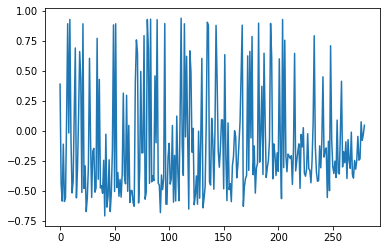

-0.11034255948745741

In [39]:
x = [i for i in V_first_visit_mv.values()] 
plt.plot(x)
plt.show()
np.mean(x)

In [2]:
def make_policy(Q, epsilon, num_A):
    def make_epsilon_greedy_strategy(observation):
        pi = np.ones(num_A, dtype=float) * epsilon / num_A
        a_star = np.argmax(Q[observation])
        pi[a_star] += (1.0 - epsilon)
        return pi
    return make_epsilon_greedy_strategy

In [3]:
def run_mc_control(env, policy):
    episode = []
    state = env.reset()
    for t in range(100):
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state
    return episode

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, gamma=1.0, epsilon=0.1):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    #state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    
    policy = make_policy(Q, epsilon, env.action_space.n)
    
    for idx in range(1, num_episodes + 1):
        if idx % 1000 == 0:
            print(f"\rEpisode {idx}/{num_episodes}.", end="")
            sys.stdout.flush()

        episode = run_mc_control(env, policy)

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            
            # first occurance
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            
            G = sum([x[2] * (gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
            
            # avg return
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

    
    return Q, policy

In [53]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, gamma=1.0, epsilon=0.1)

Episode 500000/500000.

In [54]:
V_mc_control = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V_mc_control[state] = action_value

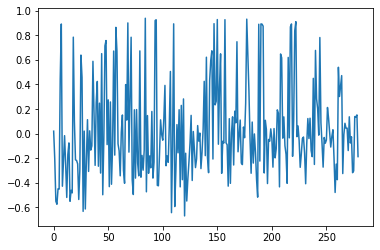

0.02639748433297589

In [55]:
x = [i for i in V_mc_control.values()] 
plt.plot(x)
plt.show()
np.mean(x)

In [5]:
def play_mc_control(env, policy):
    state = env.reset()
    for t in range(100):
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        next_state, reward, done, _ = env.step(action)
        if done:
            break
    return reward

In [6]:
def avg_mc_control(env, pi, games_num):
    rewards = [play_mc_control(env, pi) for _ in range(games_num)]
    env.close()
    return sum(rewards) / games_num
        

In [63]:
print(f"Avg reward: {avg_mc_control(env, policy, EPISODES)}")

Avg reward: -0.41712


2. Double

In [7]:
from blackjack_double import BlackjackDoubleEnv

Episode 500000/500000.

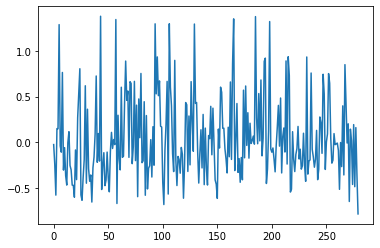

0.0438043861692046

In [8]:
env = BlackjackDoubleEnv(True)
Q_double, policy_double = mc_control_epsilon_greedy(env, num_episodes=500000, gamma=1.0, epsilon=0.1)

V_double_control = defaultdict(float)
for state, actions in Q_double.items():
    action_value = np.max(actions)
    V_double_control[state] = action_value
    
x = [i for i in V_double_control.values()] 
plt.plot(x)
plt.show()
np.mean(x)

In [ ]:
best_mean_v = 0.0438043861692046
best_gamma = 1.0
best_epsilon = 0.1
best_x = None

for epsilon, gamma in [(0.7,0.001), (0.95,0.0002), (0.02,0.0003), (0.6,0.0005), (0.5,0.005), (1.0,0.5)]:
    env = BlackjackDoubleEnv(True)
    Q_double, policy_double = mc_control_epsilon_greedy(env, num_episodes=500000, gamma=1.0, epsilon=0.1)

    V_double_control = defaultdict(float)
    for state, actions in Q_double.items():
        action_value = np.max(actions)
        V_double_control[state] = action_value

    x = [i for i in V_double_control.values()]
    current_mean = np.mean(x)
    if current_mean > best_mean_v:
        best_mean_v = current_mean
        best_gamma = gamma
        best_epsilon = epsilon
        best_x = x

epsilon:0.7, gamma:0.001, mean: 0.053948380492852645


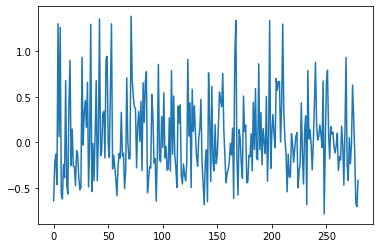

In [11]:
print(f"epsilon:{best_epsilon}, gamma:{best_gamma}, mean: {np.mean(best_x)}")
plt.plot(best_x)
plt.show()